##  Libraries

In [34]:
from __future__ import annotations

import pathlib
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Visuals / utils
from visualizations import (
    na_visualization,
    correlation_heatmap,
    plot_feature_importance,
    feature_importance_heatmap,
    plot_pca_variance,
)
from utils import detect_outliers_iqr, build_features, compute_feature_importance


In [35]:
df=pd.read_csv('data\student-data.csv')


# Introduction to the dataset 




*** BASIC INFORMATION ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-nu

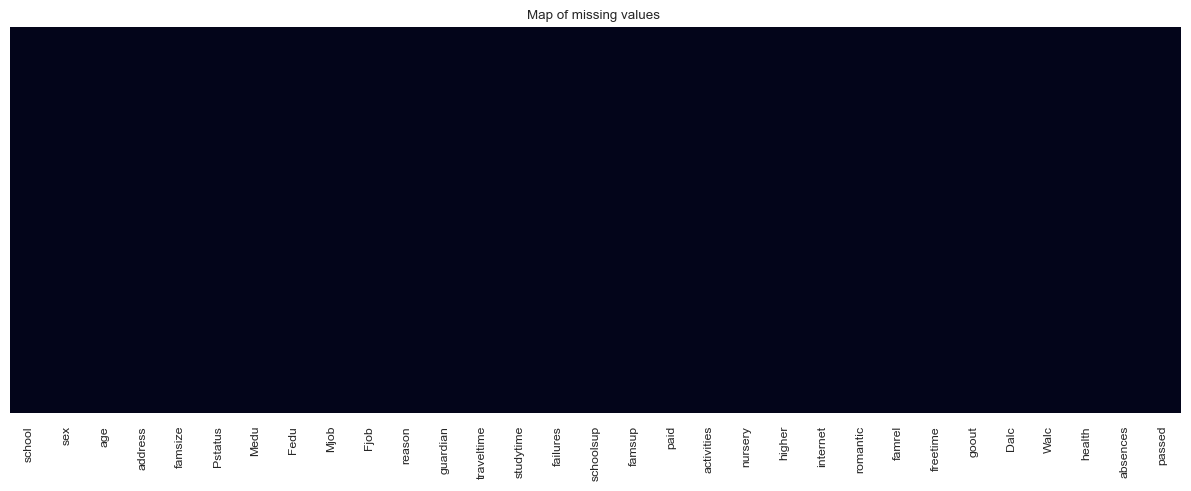

There are no missing values


In [36]:
from visualizations import na_visualization 


print("\n*** BASIC INFORMATION ***\n")
print(df.info())
print("\nShape        :", df.shape)
print("\nNumeric cols :", df.select_dtypes("number").columns.tolist())
print("Categorical  :", df.select_dtypes("object").columns.tolist())
    
print("\nClass distribution (passed):\n", df["passed"].value_counts(normalize=True).rename("passed proportion"))
na_visualization(df)


### Train/Test Split 

In [37]:
X = df.drop(columns=["passed"])
y = df["passed"]

numeric_cols = X.select_dtypes("number").columns.tolist()
categorical_cols = X.select_dtypes("object").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nSize of Train set      :", X_train.shape)
print("Size of Test set       :", X_test.shape)


Size of Train set      : (316, 30)
Size of Test set       : (79, 30)


# Preprocessing 

Cosas a mencionar  : 

No hay imputacion debido a que no hay ningun NA ni valor faltante

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
140,-1.305332,1.135587,0.462701,0.722867,2.386735,-0.442589,-2.091898,-1.272747,-1.038594,-0.554434,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
245,-0.524111,-0.667656,-1.388103,2.115708,-1.262660,-0.442589,0.093357,-0.269784,-0.136957,-0.554434,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
131,-1.305332,-1.569278,-1.388103,2.115708,-1.262660,-0.442589,0.093357,-0.269784,-0.136957,-0.554434,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
153,1.819554,0.233965,-0.462701,-0.669974,-1.262660,3.553358,0.093357,1.736141,0.764679,-0.554434,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
386,1.038332,1.135587,1.388103,2.115708,-1.262660,-0.442589,0.093357,0.733178,-0.136957,0.513866,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
50,-0.524111,-0.667656,-0.462701,2.115708,-0.046195,-0.442589,0.093357,-0.269784,-0.136957,0.513866,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
290,1.038332,1.135587,-0.462701,-0.669974,-0.046195,-0.442589,0.093357,-0.269784,-1.038594,-0.554434,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
279,1.038332,1.135587,0.462701,0.722867,-1.262660,-0.442589,0.093357,-1.272747,-0.136957,-0.554434,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
98,-0.524111,1.135587,1.388103,-0.669974,-1.262660,-0.442589,1.185985,-0.269784,0.764679,-0.554434,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
14,-1.305332,-0.667656,-0.462701,-0.669974,1.170270,-0.442589,0.093357,1.736141,-1.038594,-0.554434,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


(316, 56)

Tabla de correlaciones:
                    age  Medu  Fedu  traveltime  studytime  failures  famrel  \
age                1.00 -0.17 -0.18        0.08      -0.05      0.25    0.05   
Medu              -0.17  1.00  0.62       -0.20       0.05     -0.23    0.01   
Fedu              -0.18  0.62  1.00       -0.20      -0.02     -0.26    0.01   
traveltime         0.08 -0.20 -0.20        1.00      -0.06      0.06   -0.03   
studytime         -0.05  0.05 -0.02       -0.06       1.00     -0.19    0.02   
failures           0.25 -0.23 -0.26        0.06      -0.19      1.00   -0.04   
famrel             0.05  0.01  0.01       -0.03       0.02     -0.04    1.00   
freetime           0.07  0.05  0.01       -0.06      -0.14      0.12    0.17   
goout              0.12  0.07  0.03       -0.00      -0.10      0.16    0.07   
Dalc               0.16  0.03  0.02        0.14      -0.19      0.13   -0.07   
Walc               0.16 -0.04 -0.03        0.10      -0.26      0.15   -0.10   
healt

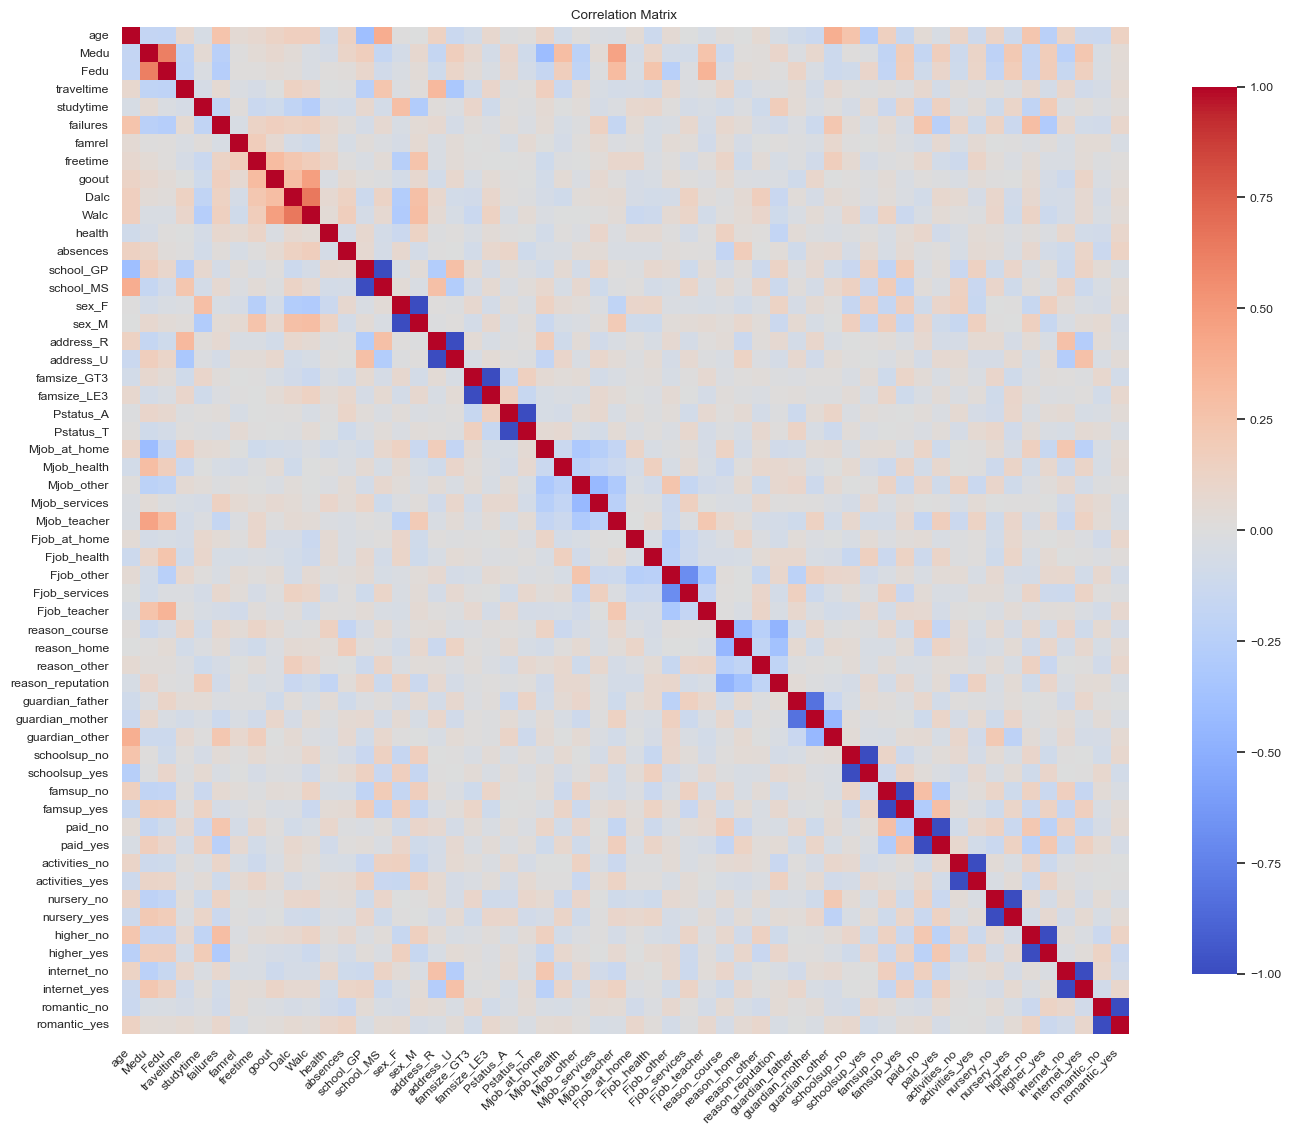

In [ ]:
from utils import detect_outliers_iqr
from importlib import reload 
from visualizations import correlation_heatmap
import visualizations
reload (visualizations)

num_cols = X_train.select_dtypes("number").columns.tolist()
cat_cols = X_train.select_dtypes("object").columns.tolist()

# Creating transformers for each type
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')


# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_cols),
        ('cat', cat_transformer, categorical_cols)
    ]
)

X_train_proc=preprocessor.fit_transform(X_train)
X_test_proc=preprocessor.transform(X_test) 

all_feature_names = list(num_cols) + preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist()


X_train = pd.DataFrame(X_train_proc, columns=all_feature_names, index=X_train.index)
X_test  = pd.DataFrame(X_test_proc , columns=all_feature_names, index=X_test.index)

display(X_train.head(10))
print(X_train.shape)


correlation_heatmap(X_train)


|   |  Par de variables                                                 |  ρ (Pearson) |  ¿Por qué resulta interesante?\*                                                                                                                                                                    |
| -- | ----------------------------------------------------------------- | ------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
|  1 | **Dalc ↔ Walc** (consumo de alcohol entre semana ↔ fin de semana) | **0,65**     | Confirma que el hábito de beber no se restringe a un solo contexto; quienes beben entre semana también tienden a hacerlo con más fuerza los fines de semana. Puede discutirse como señal de riesgo. |
|  2 | **Medu ↔ Fedu** (nivel educativo de la madre ↔ del padre)         | **0,62**     | Muestra fuerte homofilia educacional en la pareja parental; relevante para reflexionar sobre entornos con capital cultural similar y su efecto en el rendimiento.                                   |
|  3 | **goout ↔ Walc** (salir con amigos ↔ alcohol fin de semana)       | **0,47**     | Sugiere que la vida social activa se asocia a mayor consumo recreativo; combina una variable de tiempo libre con una de salud.                                                                      |
|  4 | **Medu ↔ Mjob\_teacher**                                          | **0,45**     | Era esperable que las madres que son profesoras tengan estudios altos, pero cuantificarlo ayuda a justificar por qué “Mjob” puede ser un buen proxy de capital educativo.                           |
|  5 | **Medu ↔ Mjob\_at\_home**                                         | **‑0,41**    | Patrón opuesto al anterior: madres dedicadas al hogar suelen tener menor nivel educativo; contrasta claramente con el punto 4 y refuerza la interpretación.                                         |
|  6 | **age ↔ school\_MS** (edad ↔ colegio Mousinho da Silveira)        | **0,39**     | Indica que el alumnado de MS es ligeramente mayor que el de GP (correlación negativa simétrica con `school_GP`). Puede insinuar políticas de repetición o admisiones tardías.                       |
|  7 | **age ↔ guardian\_other**                                         | **0,39**     | Estudiantes mayores reportan más frecuentemente tutores distintos de madre/padre (p.ej. ellos mismos, abuelos); abre la puerta a hablar de autonomía o situaciones familiares especiales.           |
|  8 | **Fedu ↔ Fjob\_teacher**                                          | **0,35**     | Igual que en las madres, refuerza coherencia interna del dataset y ayuda a validar variables de profesión/educación paternal.                                                                       |


## Feature Engineering 

os dejo la tabla de chapete con las features que saque

| Nº | *Feature*                    | Cómo se construye (pseudo‑código)        | Razonamiento clave                                                                    |
| -- | ---------------------------- | ---------------------------------------- | ------------------------------------------------------------------------------------- |
| 1  | **`study_efficiency_log`**   | `log(studytime + 1) − log(absences + 1)` | Relación horas de estudio / ausencias con escala logarítmica para domar los outliers. |
| 2  | **`absence_ratio`**          | `absences / (traveltime + 1)`            | Penaliza más las faltas de quienes viven cerca de la escuela.                         |
| 3  | **`absence_flag_q75`**       | `1 si absences > P75(absences)`          | Marca a los alumnos con ausencias inusualmente altas tras la limpieza.                |
| 4  | **`alcohol_index_z`**        | `0.4·z(Dalc) + 0.6·z(Walc)`              | Indicador de consumo de alcohol con pesos y escalado *z‑score*.                       |
| 5  | **`alcohol_spike_weekend`**  | `Walc − Dalc`                            | Detecta picos de ocio que pueden interferir con el estudio.                           |
| 6  | **`weekend_focus`**          | `1 si (Dalc ≤ 2 ∧ Walc ≤ 2)`             | Bandera de “buen manejo” del fin de semana.                                           |
| 7  | **`family_support_total`**   | `schoolsup_yes + famsup_yes + paid_yes`  | Suma de apoyos académicos formales e informales (0‑3).                                |
| 8  | **`support_change`**         | `schoolsup_yes − famsup_yes`             | Diferencia ayuda escuela vs. familia: revela discrepancias.                           |
| 9  | **`parent_edu_avg`**         | `(Medu + Fedu) / 2`                      | Capital educativo familiar medio.                                                     |
| 10 | **`highly_educated_parent`** | `1 si max(Medu,Fedu) ≥ 3`                | Basta que un progenitor tenga ≥ secundaria para influir positivamente.                |
| 11 | **`commute_spline_low`**     | `max(0, 2 − traveltime)`                 | Primer segmento del *spline* para capturar efecto no lineal (viajes cortos).          |
| 12 | **`commute_spline_high`**    | `max(0, traveltime − 2)`                 | Segundo segmento del *spline* (viajes largos ≥ 30 min).                               |
| 13 | **`failure_history_std`**    | `z(failures)`                            | Suspensos pasados en escala estándar.                                                 |
| 14 | **`failure_history_sq`**     | `failure_history_std²`                   | Efecto no lineal: el primer suspenso suele pesar más que los siguientes.              |
| 15 | **`fairness_sex_schoolsup`** | `sex_F × schoolsup_yes`                  | Interacción para vigilar posibles sesgos de género en el soporte escolar.             |
| 16 | **`fairness_sex_famsup`**    | `sex_F × famsup_yes`                     | Interacción equivalente con apoyo familiar.                                           |


In [39]:
import utils
reload(utils)
from utils import build_features


train_stats = {
    "q75_absences": X_train["absences"].quantile(0.75),
    "mean_dalc": X_train["Dalc"].mean(),
    "std_dalc": X_train["Dalc"].std(ddof=0) or 1,
    "mean_walc": X_train["Walc"].mean(),
    "std_walc": X_train["Walc"].std(ddof=0) or 1,
    "mean_failures": X_train["failures"].mean(),
    "std_failures": X_train["failures"].std(ddof=0) or 1,
    "median_studytime": X_train["studytime"].median(),
    "median_absences": X_train["absences"].median(),
    "median_traveltime": X_train["traveltime"].median(),
}


X_train = build_features(X_train, train_stats)
X_test = build_features(X_test, train_stats)




c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Feature Importance 

c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\visualizations.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top, palette="viridis")


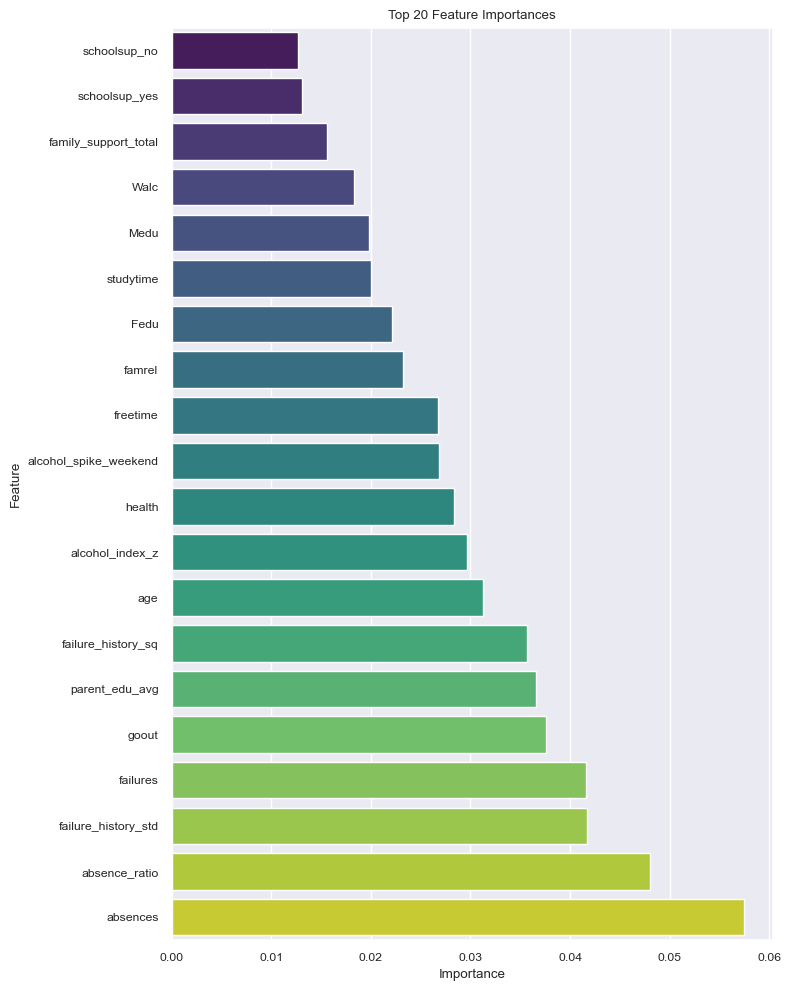

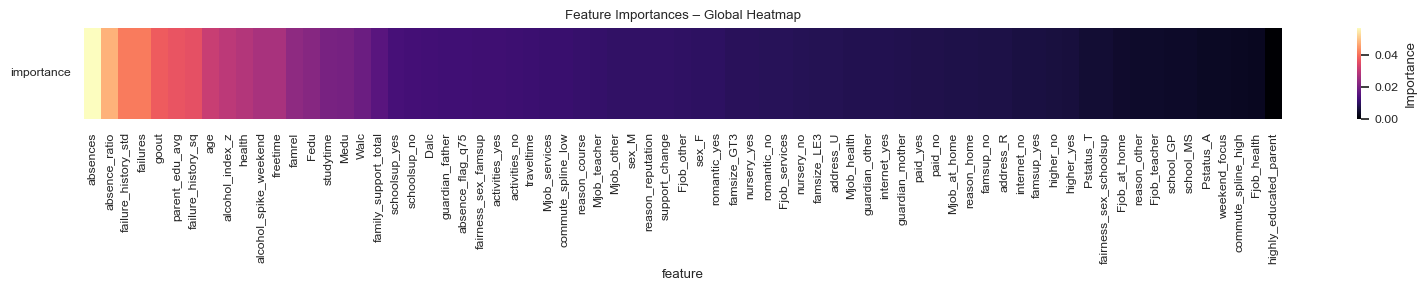

In [40]:
from visualizations import feature_importance_heatmap
importance_df, _ = compute_feature_importance(X_train, y_train)
plot_feature_importance(importance_df, top_n=20)
feature_importance_heatmap(importance_df)


Vemos que hay muchas features sin importancia vamos a ver una reduccion de dimensionalidad para ayudar al coste computacional y facilitar el manejo de memoria al reducir el tamaño de los datos 

## Dimension Reduction 

Explicar brevemente que es el PCA, con formulas y tal

Doing PCA on all preprocessed features …
Components (Kaiser criterion - covariance > mean): 8
  Cumulative variance: 0.7039
Components (Kaiser criterion - correlation > 1): 9
  Cumulative variance: 0.7339
Number of components to reach 97.5% variance: 32


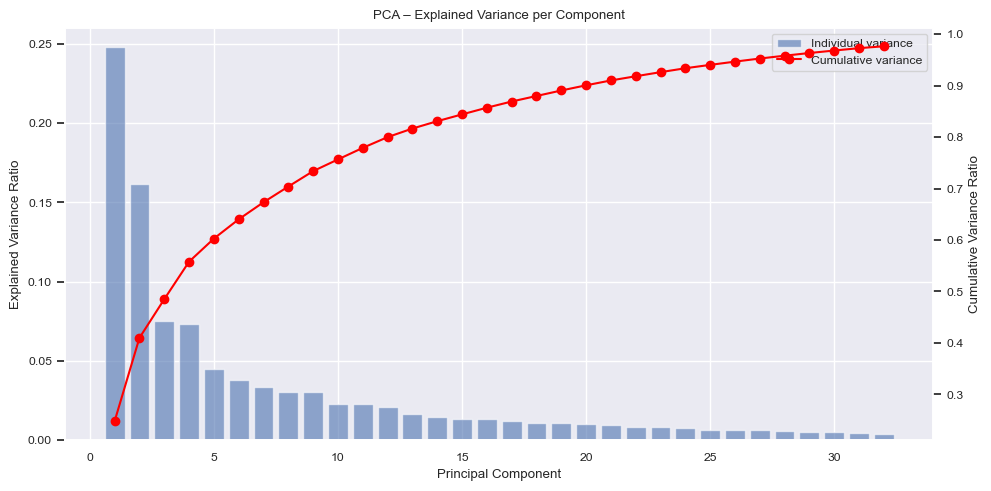

In [41]:

print("Doing PCA on all preprocessed features …")

from utils import preprocess_and_pca

X_train,X_test,pca=preprocess_and_pca(X_train,X_test)
plot_pca_variance(pca.explained_variance_ratio_)



A pesar de los resultados decidimos aumentar el numero de componentes que nos quedabamos con un número de 32



# Model creation  

## Metrics 

# Model deployment 

# Conclusion